In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
df = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


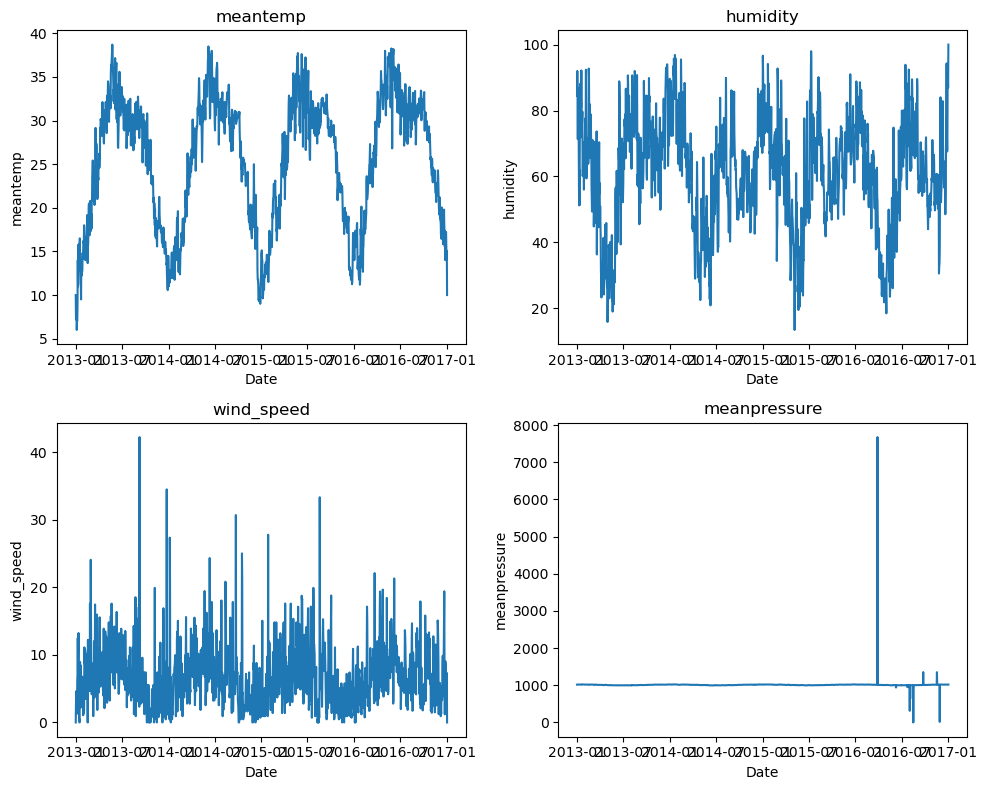

In [4]:
import matplotlib.pyplot as plt

# Criar subplots com uma matriz 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Definir os dados e os nomes das colunas
data = df['date']
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

# Iterar sobre os subplots e plotar os dados de cada coluna
for i, ax in enumerate(axs.flatten()):
    column = columns[i]
    ax.plot(data, df[column])
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

meantemp has seasonality

humidity has partly Stationarity, let's check with a hipothesys test

wind_speed has seasonality

In [5]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(df['humidity'])

(-3.675576919163344,
 0.004470100478130688,
 15,
 1446,
 {'1%': -3.434880391815318,
  '5%': -2.8635408625359315,
  '10%': -2.5678352438452814},
 9961.530007876658)

p-value = 0.004 so it has stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(df['meantemp'])

(-2.021069055920673,
 0.2774121372301602,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470953)

In [7]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(df['wind_speed'])

(-3.838096756685112,
 0.0025407221531463355,
 24,
 1437,
 {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 8107.698049704068)

In [8]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(df['meanpressure'])

(-38.07859002556161,
 0.0,
 0,
 1461,
 {'1%': -3.434833796443757,
  '5%': -2.8635202989550756,
  '10%': -2.567824293398847},
 19034.033348261542)

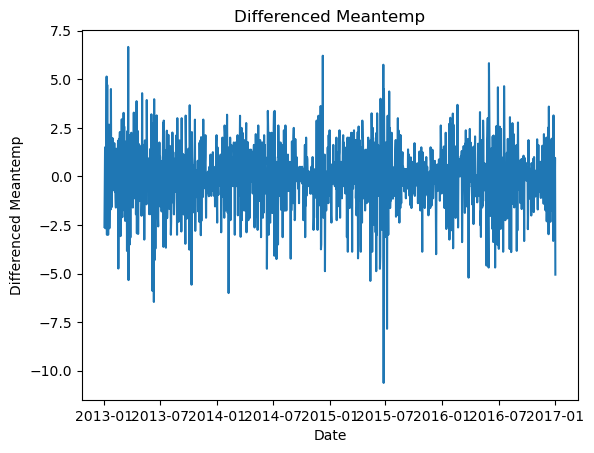

In [9]:
df['meantemp_diff'] = df['meantemp'] - df['meantemp'].shift(1)

# Remove the first row with NaN resulting from differencing
df = df.dropna()

# Plot the differenced data
plt.plot(df['date'], df['meantemp_diff'])
plt.title('Differenced Meantemp')
plt.xlabel('Date')
plt.ylabel('Differenced Meantemp')
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(df['meantemp_diff'])

(-16.378720267074687,
 2.764863137594565e-29,
 9,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.097584257939)

Now that we have all our features with stationarity, we can move on

### Simple Moving Average

In [11]:
df_ma = df.copy()
df_ma.drop('meantemp',axis=1,inplace=True)

In [12]:
cols = list(df_ma.columns)
cols.remove('date')
windows = [5, 25, 50, 100]
for c in cols:
    for window in windows:
        df_ma[f'{c}_{window}'] = df_ma[c].rolling(window=window,closed='left').mean()
y = df_ma[cols]
#df_ma = df_ma.drop(cols,axis=1)

In [13]:
df_ma.corr()

/tmp/ipykernel_20/4202172488.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_ma.corr()


,humidity,wind_speed,meanpressure,meantemp_diff,humidity_5,humidity_25,humidity_50,humidity_100,wind_speed_5,wind_speed_25,wind_speed_50,wind_speed_100,meanpressure_5,meanpressure_25,meanpressure_50,meanpressure_100,meantemp_diff_5,meantemp_diff_25,meantemp_diff_50,meantemp_diff_100
humidity,1.000000,-0.373066,0.001710,-0.197788,0.817089,0.729824,0.583403,0.231256,-0.390669,-0.447732,-0.416028,-0.293738,-0.055414,-0.197882,-0.305226,-0.309774,-0.194559,-0.392867,-0.574892,-0.683500
wind_speed,-0.373066,1.000000,-0.020660,-0.013165,-0.249181,-0.222307,-0.209960,-0.192278,0.345380,0.349424,0.323229,0.244868,-0.016646,0.020582,0.040425,0.114577,0.135170,0.256972,0.340351,0.363067
meanpressure,0.001710,-0.020660,1.000000,-0.003190,-0.006746,0.004798,0.015272,0.050366,-0.020855,-0.013701,-0.034819,-0.061135,0.009119,0.013670,0.014327,0.009583,0.007297,0.005445,0.033881,0.007081
meantemp_diff,-0.197788,-0.013165,-0.003190,1.000000,0.061178,0.019274,0.024811,0.028970,-0.008503,0.017114,0.009171,-0.016951,0.045235,0.027906,0.033450,0.031005,-0.234714,-0.127959,-0.049819,-0.031271
humidity_5,0.817089,-0.249181,-0.006746,0.061178,1.000000,0.861165,0.706032,0.316313,-0.482082,-0.524102,-0.483325,-0.351545,-0.018674,-0.184529,-0.305564,-0.338136,-0.123250,-0.397894,-0.580249,-0.729194
humidity_25,0.729824,-0.222307,0.004798,0.019274,0.861165,1.000000,0.914535,0.544754,-0.370631,-0.583082,-0.570554,-0.460542,0.003504,-0.100408,-0.270457,-0.368183,0.002547,-0.209376,-0.448698,-0.742689
humidity_50,0.583403,-0.209960,0.015272,0.024811,0.706032,0.914535,1.000000,0.776900,-0.346028,-0.554194,-0.618601,-0.564587,0.024756,-0.022060,-0.162097,-0.348735,0.040551,-0.038967,-0.264509,-0.671875
humidity_100,0.231256,-0.192278,0.050366,0.028970,0.316313,0.544754,0.776900,1.000000,-0.315080,-0.519707,-0.625885,-0.723097,0.104530,0.158878,0.074210,-0.171124,0.068269,0.125268,0.003839,-0.424375
wind_speed_5,-0.390669,0.345380,-0.020855,-0.008503,-0.482082,-0.370631,-0.346028,-0.315080,1.000000,0.675798,0.595889,0.440362,-0.042361,0.008936,0.046578,0.165230,0.038259,0.310286,0.452395,0.518370
wind_speed_25,-0.447732,0.349424,-0.013701,0.017114,-0.524102,-0.583082,-0.554194,-0.519707,0.675798,1.000000,0.907712,0.717141,-0.029593,-0.036286,0.038141,0.204240,0.073690,0.361651,0.590131,0.752268


### Exponential Moving Average

In [14]:
df_ema = df.copy()
df_ema.drop('meantemp',axis=1,inplace=True)

In [15]:
cols = list(df_ema.columns)
cols.remove('date')
windows = [5, 25, 50, 100]
for c in cols:
    for window in windows:
        df_ema[f'{c}_{window}'] = df_ema[c].shift(1).ewm(span=window).mean()
y = df_ema[cols]
#df_ma = df_ma.drop(cols,axis=1)

In [16]:
df_ema.corr()

/tmp/ipykernel_20/1175782095.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_ema.corr()


,humidity,wind_speed,meanpressure,meantemp_diff,humidity_5,humidity_25,humidity_50,humidity_100,wind_speed_5,wind_speed_25,wind_speed_50,wind_speed_100,meanpressure_5,meanpressure_25,meanpressure_50,meanpressure_100,meantemp_diff_5,meantemp_diff_25,meantemp_diff_50,meantemp_diff_100
humidity,1.000000,-0.373066,0.001710,-0.197788,0.851935,0.764093,0.662449,0.502760,-0.421693,-0.472472,-0.447910,-0.364801,-0.051202,-0.178352,-0.257114,-0.306199,-0.212220,-0.373146,-0.450351,-0.467052
wind_speed,-0.373066,1.000000,-0.020660,-0.013165,-0.271131,-0.241838,-0.234923,-0.209937,0.412049,0.370421,0.343755,0.282589,-0.018405,0.003465,0.036500,0.085907,0.133377,0.247690,0.285880,0.292869
meanpressure,0.001710,-0.020660,1.000000,-0.003190,-0.001663,0.004301,0.016946,0.034778,-0.013031,-0.018316,-0.032648,-0.052209,0.009804,0.014404,0.015160,0.010074,-0.016109,0.003037,0.009641,0.002962
meantemp_diff,-0.197788,-0.013165,-0.003190,1.000000,0.074559,0.033042,0.032874,0.040648,-0.026860,0.007487,0.002195,-0.014893,0.044191,0.039456,0.037701,0.038428,-0.253772,-0.206757,-0.134496,-0.086586
humidity_5,0.851935,-0.271131,-0.001663,0.074559,1.000000,0.917146,0.807018,0.633382,-0.485120,-0.564712,-0.535107,-0.444224,-0.023299,-0.157919,-0.252595,-0.317199,-0.132841,-0.373425,-0.481332,-0.520315
humidity_25,0.764093,-0.241838,0.004301,0.033042,0.917146,1.000000,0.962670,0.833382,-0.424166,-0.595816,-0.608521,-0.546322,-0.000615,-0.096906,-0.200115,-0.292483,-0.016951,-0.201177,-0.353232,-0.457466
humidity_50,0.662449,-0.234923,0.016946,0.032874,0.807018,0.962670,1.000000,0.946127,-0.405078,-0.604296,-0.651799,-0.628469,0.028389,-0.027541,-0.122931,-0.231688,0.016121,-0.102099,-0.252533,-0.392244
humidity_100,0.502760,-0.209937,0.034778,0.040648,0.633382,0.833382,0.946127,1.000000,-0.364910,-0.580599,-0.669609,-0.709913,0.069388,0.071675,0.003164,-0.106447,0.050063,0.006294,-0.125281,-0.292891
wind_speed_5,-0.421693,0.412049,-0.013031,-0.026860,-0.485120,-0.424166,-0.405078,-0.364910,1.000000,0.820103,0.703948,0.567392,-0.037331,-0.014810,0.035614,0.114066,0.042427,0.275022,0.375319,0.419028
wind_speed_25,-0.472472,0.370421,-0.018316,0.007487,-0.564712,-0.595816,-0.604296,-0.580599,0.820103,1.000000,0.964531,0.850100,-0.044861,-0.048524,0.003701,0.107313,0.060851,0.303909,0.450155,0.541484
